# TASK 3: Energy Consumption Forecasting

Saving household_power_consumption.csv to household_power_consumption.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoql_4szp/8wvtw4rf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoql_4szp/z1brq75g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23790', 'data', 'file=/tmp/tmpoql_4szp/8wvtw4rf.json', 'init=/tmp/tmpoql_4szp/z1brq75g.json', 'output', 'file=/tmp/tmpoql_4szp/prophet_model8asx2oro/prophet_model-20250723201254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


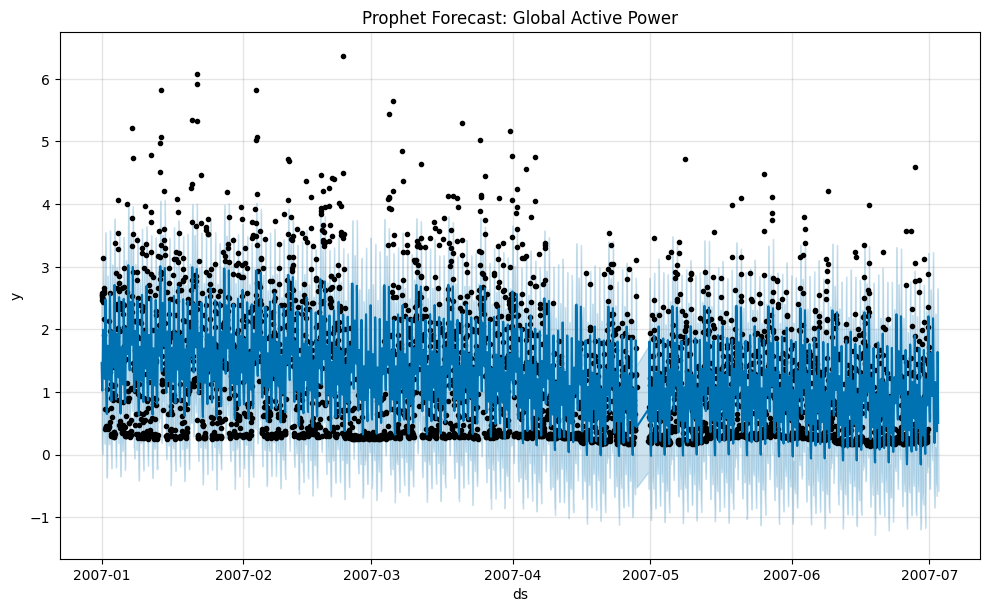

Prophet MAE: 0.5253229286858895
Prophet RMSE: 0.667128237452371


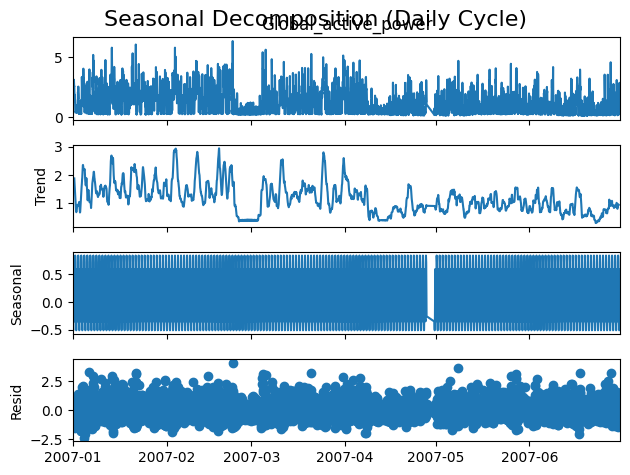

XGBoost MAE: 0.5680148281783203
XGBoost RMSE: 0.7224252886365626
ARIMA MAE: 1.0097709755976314
ARIMA RMSE: 1.1583331510889614


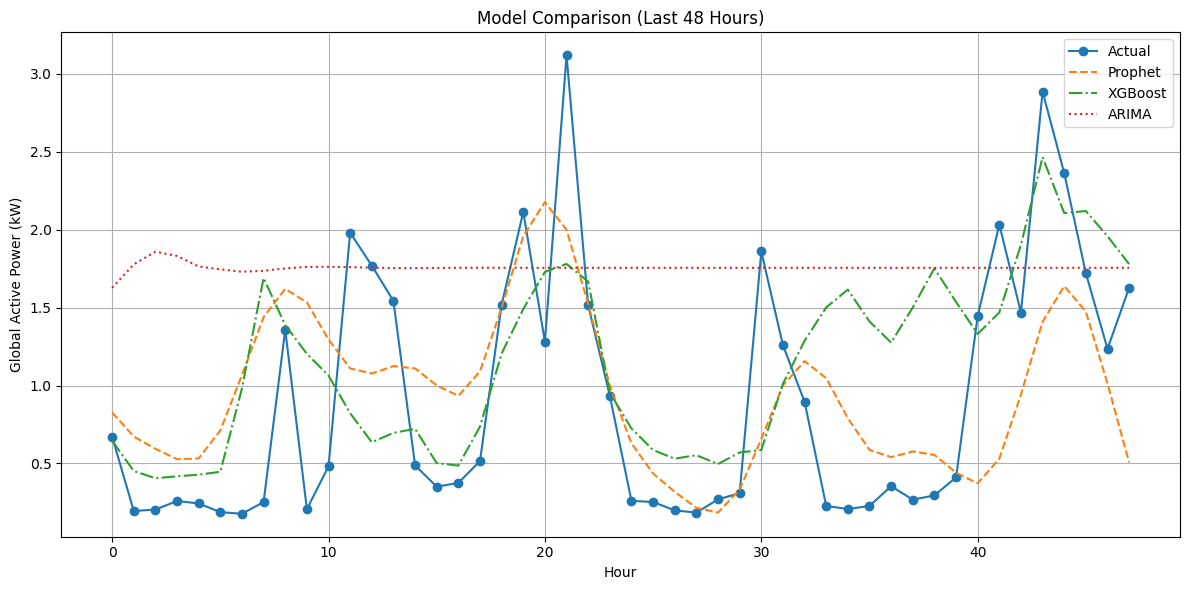

In [4]:
# STEP 1: Install required libraries
!pip install prophet --quiet
!pip install xgboost --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# STEP 3: Upload dataset
uploaded = files.upload()  # household_power_consumption.csv
df = pd.read_csv("household_power_consumption.csv", sep=",", low_memory=False)

# STEP 4: Parse and clean datetime
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True, errors="coerce")
df.dropna(subset=["Datetime"], inplace=True)
df.drop(columns=["Date", "Time"], inplace=True)

# STEP 5: Set index and preprocess
df.set_index("Datetime", inplace=True)
df = df.apply(pd.to_numeric, errors="coerce")
df = df.resample("H").mean().dropna()

# STEP 6: Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# STEP 7: Prophet Forecasting
ts = df[["Global_active_power"]].reset_index().rename(columns={"Datetime": "ds", "Global_active_power": "y"})
model_prophet = Prophet()
model_prophet.fit(ts)
future = model_prophet.make_future_dataframe(periods=48, freq="H")
forecast = model_prophet.predict(future)

# STEP 8: Prophet Plot
fig1 = model_prophet.plot(forecast)
plt.title("Prophet Forecast: Global Active Power")
plt.show()

# STEP 9: Prophet Evaluation
y_true = ts["y"].values[-48:]
y_pred = forecast["yhat"].values[-48:]
print("Prophet MAE:", mean_absolute_error(y_true, y_pred))
print("Prophet RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

# STEP 10: Seasonal Decomposition
result = seasonal_decompose(df["Global_active_power"], model="additive", period=24)
result.plot()
plt.suptitle("Seasonal Decomposition (Daily Cycle)", fontsize=16)
plt.show()

# STEP 11: XGBoost Regressor
X = df[["hour", "dayofweek", "is_weekend"]]
y = df["Global_active_power"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=48, shuffle=False)

model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))

# STEP 12: ARIMA Model
arima_series = df["Global_active_power"]
model_arima = ARIMA(arima_series, order=(5,1,0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=48)

print("ARIMA MAE:", mean_absolute_error(y_true, arima_forecast))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(y_true, arima_forecast)))

# STEP 13: Comparison Plot
plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", marker='o')
plt.plot(y_pred, label="Prophet", linestyle="--")
plt.plot(xgb_preds, label="XGBoost", linestyle="-.")
plt.plot(arima_forecast.values, label="ARIMA", linestyle=":")
plt.title("Model Comparison (Last 48 Hours)")
plt.xlabel("Hour")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
